In [1]:
import os, random, glob, pickle, collections, math
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline 

from keras.models import Sequential, Model, load_model, model_from_json
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense, LeakyReLU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing import image
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [53]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../RFCN/JPEGImages/'
TRAIN_CROP_DIR = '../data/train_crop/'
TEST_CROP_DIR = '../data/test_stg1_crop/'
RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
CROP_MODEL = 'resnet50_FT38_Classifier_Rep'
if not os.path.exists('./' + CROP_MODEL):
    os.mkdir('./' + CROP_MODEL)
CHECKPOINT_DIR = './' + CROP_MODEL + '/checkpoint/'
if not os.path.exists(CHECKPOINT_DIR):
    os.mkdir(CHECKPOINT_DIR)
LOG_DIR = './' + CROP_MODEL + '/log/'
if not os.path.exists(LOG_DIR):
    os.mkdir(LOG_DIR)
OUTPUT_DIR = './' + CROP_MODEL + '/output/'
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
# CROP_CLASSES=FISH_CLASSES[:]
# CROP_CLASSES.remove('NoF')
CONF_THRESH = 0.8
ROWS = 224
COLS = 224
BATCHSIZE = 128
LEARNINGRATE = 1e-4
def featurewise_center(x):
    mean = np.mean(x, axis=0, keepdims=True)
    mean = np.mean(mean, axis=(1,2), keepdims=True)
    x_centered = x - mean
    return x_centered

def mean(x):
    mean = np.mean(x, axis=0)
    mean = np.mean(mean, axis=(0,1))
    return mean

def load_img(path, bbox, target_size=None):
    img = Image.open(path)
#     img = img.convert('RGB')
    cropped = img.crop((bbox[0],bbox[1],bbox[2],bbox[3]))
    width_cropped, height_cropped = cropped.size
    if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
    cropped.save('try.jpg')
    cropped = Image.open('try.jpg')   
    if target_size:
        cropped = cropped.resize((target_size[1], target_size[0]), Image.BILINEAR)
    return cropped

def preprocess_input(x, mean):
    #resnet50 image preprocessing
#     'RGB'->'BGR'
#     x = x[:, :, ::-1]
#     x /= 255.
    x[:, :, 0] -= mean[0]
    x[:, :, 1] -= mean[1]
    x[:, :, 2] -= mean[2]
    return x

def get_best_model(checkpoint_dir = CHECKPOINT_DIR):
    files = glob.glob(checkpoint_dir+'*')
    val_losses = [float(f.split('-')[-1][:-5]) for f in files]
    index = val_losses.index(min(val_losses))
    print('Loading model from checkpoint file ' + files[index])
    model = load_model(files[index])
    model_name = files[index].split('/')[-1]
    print('Loading model Done!')
    return (model, model_name)

In [3]:
# GTbbox_df = ['image_file','crop_index','crop_class','xmin',''ymin','xmax','ymax']

file_name = 'GTbbox_df.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    GTbbox_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)       
    GTbbox_df = pd.DataFrame(columns=['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax'])  

    crop_classes=FISH_CLASSES[:]
    crop_classes.remove('NoF')
    
    for c in crop_classes:
        print(c)
        j = json.load(open('../data/BBannotations/{}.json'.format(c), 'r'))
        for l in j: 
            filename = l["filename"]
            head, image_file = os.path.split(filename)
            basename, file_extension = os.path.splitext(image_file) 
            image = Image.open(TEST_DIR+'/'+image_file)
            width_image, height_image = image.size
            for i in range(len(l["annotations"])):
                a = l["annotations"][i]
                xmin = (a["x"])
                ymin = (a["y"])
                width = (a["width"])
                height = (a["height"])
                xmax = xmin + width
                ymax = ymin + height
                assert max(xmin,0)<min(xmax,width_image)
                assert max(ymin,0)<min(ymax,height_image)
                GTbbox_df.loc[len(GTbbox_df)]=[image_file,i,a["class"],max(xmin,0),max(ymin,0),min(xmax,width_image),min(ymax,height_image)]
                if a["class"] != c: print(GTbbox_df.tail(1))  
        
        
    num_NoF = GTbbox_df.shape[0]*3
    RFCN_MODEL = 'resnet101_rfcn_ohem_iter_30000'
    with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
        detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    train_detections_full_AGNOSTICnms = detections_full_AGNOSTICnms[1000:]
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    train_files = test_files[1000:]
    num_NoF_perIm = math.ceil(num_NoF / len(train_detections_full_AGNOSTICnms))

    for im in range(len(train_files)):
        image_file = train_files[im][:-1]+'.jpg'
        image = Image.open(TEST_DIR+image_file)
        width_image, height_image = image.size
        detects_im = train_detections_full_AGNOSTICnms[im]
        detects_im = detects_im[np.where(detects_im[:,4] >= 0.999)]
        bboxes = detects_im[np.random.choice(detects_im.shape[0], num_NoF_perIm, replace=False), :]
        for j in range(bboxes.shape[0]):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            assert max(xmin,0)<min(xmax,width_image)
            assert max(ymin,0)<min(ymax,height_image)
            GTbbox_df.loc[len(GTbbox_df)]=[image_file,j,'NoF',max(xmin,0),max(ymin,0),min(xmax,width_image),min(ymax,height_image)]

    GTbbox_df.to_pickle(OUTPUT_DIR+file_name)  

Loading from file GTbbox_df.pickle


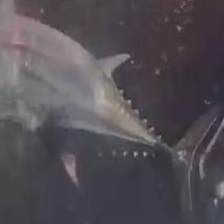

In [4]:
row = GTbbox_df.loc[959]
image_file = row['image_file']
fish = row['crop_class']
bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
cropped

In [4]:
#compute featuresise_center to add to preprocessing

# with open(OUTPUT_DIR+'featurewise_center.pickle', 'rb') as f:
#     mean = pickle.load(f)

# mean = featurewise_center(X_train_crop)
# with open(OUTPUT_DIR+'featurewise_center.pickle', 'wb') as f:
#     pickle.dump(mean, f)
    
file_name = 'data_train_Crop_{}_{}.pickle'.format(ROWS, COLS)
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    with open(OUTPUT_DIR+file_name, 'rb') as f:
        data_train = pickle.load(f)
    X_train_crop = data_train['X_train_crop']
    y_train_crop = data_train['y_train_crop']
else:
    print ('Generating file '+file_name)

    X_train_crop = np.ndarray((GTbbox_df.shape[0], ROWS, COLS, 3), dtype=np.uint8)
    y_train_crop = np.zeros((GTbbox_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
    i = 0
    for index,row in GTbbox_df.iterrows():
        image_file = row['image_file']
        fish = row['crop_class']
        bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
        cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
        X_train_crop[i] = np.asarray(cropped)
        y_train_crop[i,FISH_CLASSES.index(fish)] = 1
        i += 1
   
    #save data to file
    data_train = {'X_train_crop': X_train_crop,'y_train_crop': y_train_crop}
    with open(OUTPUT_DIR+file_name, 'wb') as f:
        pickle.dump(data_train, f)
        
print('Loading data done.')
X_train_crop = X_train_crop.astype(np.float32)
print('Convert to float32 done.')
X_train_crop /= 255.
print('Rescale by 255 done.')
# #traing stg1 and stg2 and resume should have the same train test split!!! Remenber to set the random_state!
# X_train, X_valid, y_train, y_valid = train_test_split(X_train_crop, y_train_crop, test_size=0.2, random_state=1986, stratify=y_train_crop)

Loading from file data_train_Crop_224_224.pickle


In [ ]:
# #class weight = n_samples / (n_classes * np.bincount(y))
# class_weight_fish = dict(GTbbox_df.groupby('crop_class').size())
# class_weight = {}
# n_samples = GTbbox_df.shape[0]
# for key,value in class_weight_fish.items():
#         class_weight[CROP_CLASSES.index(key)] = n_samples / (len(CROP_CLASSES)*value)
# class_weight

class_weight_fish = dict(GTbbox_df.groupby('crop_class').size())
class_weight = {}
ref = max(class_weight_fish.values())
for key,value in class_weight_fish.items():
    class_weight[FISH_CLASSES.index(key)] = ref/value
class_weight

In [ ]:
#data preprocessing

train_datagen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCHSIZE, shuffle=True, seed=None)

valid_datagen = ImageDataGenerator(featurewise_center=True)
valid_datagen.fit(X_valid) 
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BATCHSIZE, shuffle=True, seed=None)

In [ ]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath=CHECKPOINT_DIR+'weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir=LOG_DIR, histogram_freq=0, write_graph=False, write_images=True)


In [ ]:
#Resnet50
#top layer training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)
# x = Dense(256, init='glorot_normal', activation='relu')(x)
# x = LeakyReLU(alpha=0.33)(x)
# x = Dropout(0.5)(x)
# x = Dense(256, init='glorot_normal', activation='relu')(x)
# x = Dense(256, init='glorot_normal')(x)
# x = LeakyReLU(alpha=0.33)(x)
# x = Dropout(0.5)(x)
predictions = Dense(len(FISH_CLASSES), init='glorot_normal', activation='softmax')(x)

model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LEARNINGRATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=30, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), class_weight=class_weight, nb_worker=3, pickle_safe=True)

In [ ]:
# Resnet50
# fine tuning
# 164 conv5c+top
# 142 conv5+top
# 80 conv4+conv5+top
# 38 conv3+conv4+conv5+top
start_layer = 38

model, model_name = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

for layer in model.layers[:start_layer]:
   layer.trainable = False
for layer in model.layers[start_layer:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), class_weight=class_weight, nb_worker=3, pickle_safe=True)

In [ ]:
#resume training

model, model_name = get_best_model()
# print('Loading model from weights.004-0.0565.hdf5')
# model = load_model('./checkpoints/checkpoint3/weights.004-0.0565.hdf5')

model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=100, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), class_weight=class_weight, nb_worker=3, pickle_safe=True)

In [16]:
#test prepare

test_model, test_model_name = get_best_model(checkpoint_dir='./resnet50_FT38_CW_STGTrain/checkpoint/')
# print('Loading model from weights.004-0.0565.hdf5')
# test_model = load_model('./checkpoints/checkpoint2/weights.004-0.0565.hdf5')

def test_generator(df, mean, datagen = None, batch_size = BATCHSIZE):
    n = df.shape[0]
    batch_index = 0
    while 1:
        current_index = batch_index * batch_size
        if n >= current_index + batch_size:
            current_batch_size = batch_size
            batch_index += 1    
        else:
            current_batch_size = n - current_index
            batch_index = 0        
        batch_df = df[current_index:current_index+current_batch_size]
        batch_x = np.zeros((batch_df.shape[0], ROWS, COLS, 3), dtype=K.floatx())
        i = 0
        for index,row in batch_df.iterrows():
            image_file = row['image_file']
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            cropped = load_img(TEST_DIR+image_file,bbox,target_size=(ROWS,COLS))
            x = np.asarray(cropped, dtype=K.floatx())
            x /= 255.
            if datagen is not None: x = datagen.random_transform(x)            
            x = preprocess_input(x, mean)
            batch_x[i] = x
            i += 1
        if batch_index%50 == 0: print('batch_index', batch_index)
        yield(batch_x)
        
test_aug_datagen = ImageDataGenerator(
    rotation_range=180,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

Loading model from checkpoint file ./resnet50_FT38_CW_STGTrain/checkpoint/weights.000-0.0327.hdf5
Loading model Done!


In [17]:
train_mean = [0.37698776,  0.41491762,  0.38681713]

In [ ]:
train_mean = train_datagen.mean
valid_mean = valid_datagen.mean
X_train_centered = featurewise_center(X_train)
X_valid_centered = featurewise_center(X_valid)

In [ ]:
#validation data fish logloss
 
valid_pred = test_model.predict(X_valid_centered, batch_size=BATCHSIZE, verbose=1)
# valid_pred = test_model.predict_generator(test_generator(df=valid_df, mean=valid_mean),
#                                           val_samples=valid_df.shape[0], nb_worker=1, pickle_safe=False)
valid_logloss_df = pd.DataFrame(columns=['logloss','class'])
for i in range(y_valid.shape[0]):
    index = np.argmax(y_valid[i,:])
    fish = FISH_CLASSES[index]
    logloss = -math.log(valid_pred[i,index])
    valid_logloss_df.loc[len(valid_logloss_df)]=[logloss,fish]                                       
print(valid_logloss_df.groupby(['class'])['logloss'].mean())
print(valid_logloss_df['logloss'].mean())

train_pred = test_model.predict(X_train_centered, batch_size=BATCHSIZE, verbose=1)
# train_pred = test_model.predict_generator(test_generator(df=train_df, ),
#                                           val_samples=train_df.shape[0], nb_worker=1, pickle_safe=False)
train_logloss_df = pd.DataFrame(columns=['logloss','class'])
for i in range(y_train.shape[0]):
    index = np.argmax(y_train[i,:])
    fish = FISH_CLASSES[index]
    logloss = -math.log(train_pred[i,index])
    train_logloss_df.loc[len(train_logloss_df)]=[logloss,fish]                                       
print(train_logloss_df.groupby(['class'])['logloss'].mean())
print(train_logloss_df['logloss'].mean())

In [19]:
#GTbbox_CROPpred_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#                      'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'logloss']

file_name = 'GTbbox_CROPpred_df_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    GTbbox_CROPpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name) 
    nb_augmentation = 1
    if nb_augmentation ==1:
        test_preds = test_model.predict_generator(test_generator(df=GTbbox_df, mean=train_mean), 
                                                  val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
    else:
        test_preds = np.zeros((GTbbox_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
        for idx in range(nb_augmentation):
            print('{}th augmentation for testing ...'.format(idx+1))
            test_preds += test_model.predict_generator(test_generator(df=GTbbox_df, mean=train_mean, datagen=test_aug_datagen), 
                                                       val_samples=GTbbox_df.shape[0], nb_worker=1, pickle_safe=False)
        test_preds /= nb_augmentation

    CROPpred_df = pd.DataFrame(test_preds, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
    GTbbox_CROPpred_df = pd.concat([GTbbox_df,CROPpred_df], axis=1)
    GTbbox_CROPpred_df['logloss'] = GTbbox_CROPpred_df.apply(lambda row: -math.log(row[row['crop_class']]), axis=1)
    GTbbox_CROPpred_df.to_pickle(OUTPUT_DIR+file_name) 

#logloss of every fish class
print(GTbbox_CROPpred_df.groupby(['crop_class'])['logloss'].mean())
print(GTbbox_CROPpred_df['logloss'].mean())

Generating file GTbbox_CROPpred_df_weights.000-0.0327.hdf5_.pickle
batch_index 50
batch_index 100
batch_index 150
batch_index 0
crop_class
ALB      0.076577
BET      0.139025
DOL      0.126520
LAG      0.000761
NoF      0.051943
OTHER    0.133949
SHARK    0.018328
YFT      0.090739
Name: logloss, dtype: float64
0.05936252678272253


In [ ]:
ALB      0.077599
BET      0.137985
DOL      0.127548
LAG      0.000765
NoF      0.052039
OTHER    0.103720
SHARK    0.035872
YFT      0.088832
Name: logloss, dtype: float64
0.059134145372682786

In [52]:
# RFCNbbox_RFCNpred_df = ['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
#                          'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                          'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']
# select fish_conf >= CONF_THRESH

file_name = 'RFCNbbox_RFCNpred_df_conf{:.2f}.pickle'.format(CONF_THRESH)
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    RFCNbbox_RFCNpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)        
    RFCNbbox_RFCNpred_df = pd.DataFrame(columns=['image_class','image_file','crop_index','xmin','ymin','xmax','ymax',
                                                  'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
                                                  'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN']) 

    with open('../data/RFCN_detections/detections_full_AGNOSTICnms_'+RFCN_MODEL+'.pkl','rb') as f:
        detections_full_AGNOSTICnms = pickle.load(f, encoding='latin1') 
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
        train_file_labels = f.readlines()
    assert len(detections_full_AGNOSTICnms) == len(test_files)
    
    count = np.zeros(len(detections_full_AGNOSTICnms))
    
    for im in range(len(detections_full_AGNOSTICnms)):
        if im%1000 == 0: print(im)
        basename = test_files[im][:9]
        if im<1000:
            image_class = '--'
        else:
            for i in range(len(train_file_labels)):
                if train_file_labels[i][:9] == basename:
                    image_class = train_file_labels[i][10:-1]
                    break
        image = Image.open(TEST_DIR+'/'+basename+'.jpg')
        width_image, height_image = image.size
        
        bboxes = []
        detects_im = detections_full_AGNOSTICnms[im]
        for i in range(len(detects_im)):
#             if np.sum(detects_im[i,5:]) >= CONF_THRESH:
            if np.max(detects_im[i,5:]) >= CONF_THRESH:
                bboxes.append(detects_im[i,:]) 
        count[im] = len(bboxes)
        if len(bboxes) == 0:
            ind = np.argmax(np.sum(detects_im[:,5:], axis=1))
            bboxes.append(detects_im[ind,:])
        bboxes = np.asarray(bboxes)

        for j in range(len(bboxes)):    
            bbox = bboxes[j]
            xmin = bbox[0]
            ymin = bbox[1]
            xmax = bbox[2]
            ymax = bbox[3]
            assert max(xmin,0)<min(xmax,width_image)
            assert max(ymin,0)<min(ymax,height_image)
            RFCNbbox_RFCNpred_df.loc[len(RFCNbbox_RFCNpred_df)]=[image_class,basename+'.jpg',j,max(xmin,0),max(ymin,0),
                                                                   min(xmax,width_image),min(ymax,height_image),
                                                                   bbox[4],bbox[5],bbox[6],bbox[7],bbox[8],bbox[9],bbox[10],bbox[11]]   
    
    RFCNbbox_RFCNpred_df.to_pickle(OUTPUT_DIR+file_name)      

Loading from file RFCNbbox_RFCNpred_df_conf0.80.pickle


In [54]:
test_mean = [0.41019869,  0.43978861,  0.39873621]

In [57]:
# RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = ['image_class', 'image_file','crop_index','xmin','ymin','xmax','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN',
#                                    'NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP',
#                                    'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

file_name = 'RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)  
#     nb_augmentation = 1
#     if nb_augmentation ==1:
#         test_preds = test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df, mean=test_mean), 
#                                                   val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
#     else:
#         test_preds = np.zeros((RFCNbbox_RFCNpred_df.shape[0], len(FISH_CLASSES)), dtype=K.floatx())
#         for idx in range(nb_augmentation):
#             print('{}th augmentation for testing ...'.format(idx+1))
#             test_preds += test_model.predict_generator(test_generator(df=RFCNbbox_RFCNpred_df, mean=test_mean, datagen=test_aug_datagen), 
#                                                        val_samples=RFCNbbox_RFCNpred_df.shape[0], nb_worker=1, pickle_safe=False)
#         test_preds /= nb_augmentation

    CROPpred_df = pd.DataFrame(test_preds, columns=['ALB_CROP', 'BET_CROP', 'DOL_CROP', 'LAG_CROP', 'NoF_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP'])
    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = pd.concat([RFCNbbox_RFCNpred_df,CROPpred_df], axis=1)
    
#     RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['NoF'] = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['NoF_RFCN']
#     for fish in ['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']:
#         RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df[fish] = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.apply(lambda row: (1-row['NoF_RFCN'])*row[[fish+'_CROP']]/(1-row['NoF_CROP']) if row['NoF_CROP']!=1 else 0, axis=1)
    for fish in FISH_CLASSES:
        RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df[fish] = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df[fish+'_CROP']

    RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.to_pickle(OUTPUT_DIR+file_name) 

Generating file RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df_weights.000-0.0327.hdf5_.pickle


In [60]:
# clsMaxAve and hybrid RFCNpred&CROPpred such that RFCNpred for NoF and CROPpred for fish
# test_pred_df = ['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
# RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df = ['image_class', 'image_file','crop_index','xmin','ymin','xmax','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN',
#                                    'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP',
#                                    'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

file_name = 'test_pred_df_Hybrid_'+test_model_name+'_.pickle'
if os.path.exists(OUTPUT_DIR+file_name):
    print ('Loading from file '+file_name)
    test_pred_df = pd.read_pickle(OUTPUT_DIR+file_name)
else:
    print ('Generating file '+file_name)  
    with open("../RFCN/ImageSets/Main/test.txt","r") as f:
        test_files = f.readlines()
    
    test_pred_df = pd.DataFrame(columns=['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT'])  
    for j in range(len(test_files)): 
        image_file = test_files[j][:-1]+'.jpg'
        test_pred_im_df = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.loc[RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['image_file'] == image_file,
                                                                       ['image_class', 'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']]
        image_class = test_pred_im_df.iloc[0]['image_class']
        test_pred_im_df.drop('image_class', axis=1, inplace=True)
        max_score = test_pred_im_df.max(axis=1)
        max_cls = test_pred_im_df.idxmax(axis=1)
        test_pred_im_df['max_score'] = max_score
        test_pred_im_df['max_cls'] = max_cls
        test_pred_im_df['Count'] = test_pred_im_df.groupby(['max_cls'])['max_cls'].transform('count')
        idx = test_pred_im_df.groupby(['max_cls'])['max_score'].transform(max) == test_pred_im_df['max_score']
        test_pred_im_clsMax_df = test_pred_im_df.loc[idx,['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'Count']]
        test_pred_im_clsMax_array = test_pred_im_clsMax_df.values
        pred = np.average(test_pred_im_clsMax_array[:,:-1], axis=0, weights=test_pred_im_clsMax_array[:,-1], returned=False).tolist()
        if image_class!='--':
            ind = FISH_CLASSES.index(image_class)
            logloss = -math.log(pred[ind]) 
        else:
            logloss = np.nan
        test_pred_im_clsMaxAve = [logloss,image_class,image_file]
        test_pred_im_clsMaxAve.extend(pred)
        test_pred_df.loc[len(test_pred_df)]=test_pred_im_clsMaxAve

    test_pred_df.to_pickle(OUTPUT_DIR+file_name) 

Generating file test_pred_df_Hybrid_weights.000-0.0327.hdf5_.pickle


In [ ]:
#### visualization
# RFCNbbox_RFCNpred_CROPpred_df = ['image_class', 'image_file','crop_index','x_min','y_min','x_max','ymax',
#                                    'NoF_RFCN', 'ALB_RFCN', 'BET_RFCN', 'DOL_RFCN',
#                                    'LAG_RFCN', 'OTHER_RFCN', 'SHARK_RFCN', 'YFT_RFCN'
#                                    'NoF_CROP', 'ALB_CROP', 'BET_CROP', 'DOL_CROP',
#                                    'LAG_CROP', 'OTHER_CROP', 'SHARK_CROP', 'YFT_CROP']
#GTbbox_CROPpred_df = ['image_file','crop_index','crop_class','xmin','ymin','xmax','ymax',
#                      'NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT', 'logloss']
# test_pred_df = ['logloss','image_class','image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']

for j in range(test_pred_df.shape[0]):
    image_logloss = test_pred_df.iat[j,0]
    image_class = test_pred_df.iat[j,1]
    image_file = test_pred_df.iat[j,2]
    if image_logloss > 5:
        im = Image.open('../RFCN/JPEGImages/'+image_file)
        im = np.asarray(im)
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.imshow(im, aspect='equal')
        RFCN_dets = RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df.loc[RFCNbbox_RFCNpred_CROPpred_HYBRIDpred_df['image_file']==image_file]
        for index,row in RFCN_dets.iterrows():
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            RFCN = [row['NoF_RFCN'],row['ALB_RFCN'],row['BET_RFCN'],row['DOL_RFCN'],row['LAG_RFCN'],row['OTHER_RFCN'],row['SHARK_RFCN'],row['YFT_RFCN']]
            CROP = [row['NoF'],row['ALB'],row['BET'],row['DOL'],row['LAG'],row['OTHER'],row['SHARK'],row['YFT']]
            score_RFCN = max(RFCN)
            score_CROP = max(CROP)
            index_RFCN = RFCN.index(score_RFCN)
            index_CROP = CROP.index(score_CROP)
            class_RFCN = FISH_CLASSES[index_RFCN]
            class_CROP = FISH_CLASSES[index_CROP]
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='red', linewidth=2))
            ax.text(bbox[0], bbox[1] - 2, 'RFCN_{:s} {:.3f} \nHYBRID_{:s} {:.3f}'.format(class_RFCN, score_RFCN, class_CROP, score_CROP), bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white')       
        GT_dets = GTbbox_CROPpred_df.loc[GTbbox_CROPpred_df['image_file']==image_file]
        for index,row in GT_dets.iterrows():
            bbox = [row['xmin'],row['ymin'],row['xmax'],row['ymax']]
            CROP = [row['ALB'],row['BET'],row['DOL'],row['LAG'],row['OTHER'],row['SHARK'],row['YFT']]
            score_CROP = max(CROP)
            index_CROP = CROP.index(score_CROP)
            class_CROP = CROP_CLASSES[index_CROP]
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, edgecolor='green', linewidth=2))
            ax.text(bbox[0], bbox[3] + 40, 'GT_{:s} \nCROP_{:s} {:.3f}'.format(row[2], class_CROP, score_CROP), bbox=dict(facecolor='green', alpha=0.5), fontsize=8, color='white')
        ax.set_title(('Image {:s}    FISH {:s}    logloss {}').format(image_file, image_class, image_logloss), fontsize=10) 
        plt.axis('off')
        plt.tight_layout()
        plt.draw()

In [61]:
#temperature
T = 2.5
test_pred_array = test_pred_df[FISH_CLASSES].values
test_pred_T_array = np.exp(np.log(test_pred_array)/T)
test_pred_T_array = test_pred_T_array/np.sum(test_pred_T_array, axis=1, keepdims=True)
test_pred_T_df = pd.DataFrame(test_pred_T_array, columns=FISH_CLASSES)
test_pred_T_df = pd.concat([test_pred_df[['image_class','image_file']],test_pred_T_df], axis=1)

#add logloss
test_pred_T_df['logloss'] = test_pred_T_df.apply(lambda row: -math.log(row[row['image_class']]) if row['image_class']!='--' else np.nan, axis=1)

#calculate train logloss
print(test_pred_T_df.groupby(['image_class'])['logloss'].mean())
train_logloss = test_pred_T_df['logloss'].mean()
print('logloss of train is', train_logloss )

image_class
--            NaN
ALB      0.162973
BET      0.183628
DOL      0.133640
LAG      0.015996
NoF      0.370421
OTHER    0.102338
SHARK    0.135090
YFT      0.152516
Name: logloss, dtype: float64
logloss of train is 0.17795884691494246


In [62]:
#test submission
submission = test_pred_T_df.loc[:999,['image_file','NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']]
submission.rename(columns={'image_file':'image'}, inplace=True)
sub_file = 'RFCN_AGONOSTICnms_'+RFCN_MODEL+'_'+CROP_MODEL+'_clsMaxAve_conf{:.2f}_T{}_'.format(CONF_THRESH, T)+'{:.4f}'.format(train_logloss)+'.csv'
submission.to_csv(sub_file, index=False)
print('Done!'+sub_file)

Done!RFCN_AGONOSTICnms_resnet101_rfcn_ohem_iter_30000_resnet50_FT38_Classifier_Rep_clsMaxAve_conf0.80_T2.5_0.1780.csv


In [83]:
with open('../data/data_test_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
    data_test = pickle.load(f)
X_test_crop = data_test['X_test_crop']
test_crop_files = data_test['test_crop_files']

print('Loading data done.')
X_test_crop = X_test_crop.astype(np.float32)
print('Convert to float32 done.')
X_test_crop /= 255.
print('Rescale by 255 done.')

Loading data done.
Convert to float32 done.
Rescale by 255 done.


In [ ]:
test_model = load_model('./resnet50_FT38_CW_STGTrain/checkpoint/weights.014-0.0369.hdf5')

In [ ]:
X_test_crop_centered = featurewise_center(X_test_crop)
test_crop_preds = test_model.predict(X_test_crop_centered, batch_size=BATCHSIZE, verbose=1)

5120/6037 [========================>.....] - ETA: 9s 

In [ ]:
with open("../RFCN/ImageSets/Main/test.txt","r") as f:
    ims = f.readlines()
test_files = [im[:-1]+'.jpg' for im in ims]

count = np.zeros(len(test_files))

test_preds = np.ndarray((len(test_files), test_crop_preds.shape[1]), dtype=np.float32)
for j in range(len(test_files)):
    if j%1000 == 0:
        print(j)
    file = test_files[j]
    test_preds_im = []
    for i in range(len(test_crop_files)):
        if test_crop_files[i][:9] == file[:9]:
            test_preds_im.append(test_crop_preds[i])
    test_preds_im = np.asarray(test_preds_im)
    score_max = np.max(test_preds_im, axis=1)
    inds = np.argmax(test_preds_im, axis=1)
    labels = [FISH_CLASSES[ind] for ind in inds]
    columns = FISH_CLASSES[:]
    test_preds_im_df = pd.DataFrame(test_preds_im, columns=columns)
    test_preds_im_df['max_cls'] = labels
    test_preds_im_df['max_score'] = score_max 
    test_preds_im_df['Counts'] = test_preds_im_df.groupby(['max_cls'])['max_cls'].transform('count')
    idx = test_preds_im_df.groupby(['max_cls'])['max_score'].transform(max) == test_preds_im_df['max_score']
    test_preds_im_df = test_preds_im_df[idx]
    count[j] = test_preds_im_df.shape[0]
    l = FISH_CLASSES.copy()
    l.append('Counts')
    test_preds_im_array = test_preds_im_df[l].as_matrix() 
    test_preds[j] = np.average(test_preds_im_array[:,:-1], axis=0, weights=test_preds_im_array[:,-1], returned=False)

In [ ]:
#temperature
T = 2.5
test_preds_T = np.exp(np.log(test_preds)/T)
test_preds_T = test_preds_T/np.sum(test_preds_T, axis=1, keepdims=True)

In [ ]:
#calculate train logloss
FISH_CLASSES_2 = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

train_files = test_files[1000:]
train_preds = test_preds_T[1000:,:]
with open("../RFCN/ImageSets/Main/train_test.txt","r") as f:
    train_file_labels = f.readlines()

logloss_df = pd.DataFrame(columns=['image_class','logloss'])
for i in range(len(train_preds)):
    im = train_files[i][:-4]
    for im_label in train_file_labels:
        if im_label[:9] == im:
            label = im_label[10:-1]
            index = FISH_CLASSES_2.index(label)
            logloss_df.loc[len(logloss_df)]=[label,-math.log(train_preds[i,index])]
#             log_losses.append(-math.log(train_preds[i,index]))

print(logloss_df.groupby(['image_class'])['logloss'].mean())
train_logloss = logloss_df['logloss'].mean()
print('logloss of train is', train_logloss )

In [ ]:
image_class
ALB      0.226492
BET      0.303777
DOL      0.254882
LAG      0.033155
NoF      0.447992
OTHER    0.163935
SHARK    0.131572
YFT      0.227942
Name: logloss, dtype: float64
logloss of train is 0.24621065547851018
image_class
ALB      0.207327
BET      0.189047
DOL      0.111698
LAG      0.019987
NoF      0.426936
OTHER    0.080606
SHARK    0.122777
YFT      0.118584
Name: logloss, dtype: float64
logloss of train is 0.1958932319599284
image_class
--            NaN
ALB      0.162973
BET      0.183628
DOL      0.133640
LAG      0.015996
NoF      0.370421
OTHER    0.102338
SHARK    0.135090
YFT      0.152516
Name: logloss, dtype: float64
logloss of train is 0.17795884691494246

In [91]:
#test submission
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
submission = pd.DataFrame(test_preds_T[:1000,:], columns=FISH_CLASSES)
submission.insert(0, 'image', test_files[:1000])

info = 'RFCN_AGONOSTICnms_'+RFCN_MODEL+'_BBCROP_resnet50_clsMaxAve_conf{:.2f}_T{}_'.format(CONF_THRESH, T) + '{:.4f}'.format(log_loss)
sub_file = 'submission_' + info + '.csv'
submission.to_csv(sub_file, index=False)